In [1]:
import os
import torch
import torch.nn as nn


from config import get_config
from data.loader import get_dataloaders
from models.model import create_model
from train_utils.resume import init_resume_state
from train_utils.resume import fill_trackers_from_history
from train_utils.train_epoch import train_one_epoch
from train_utils.evaluate import evaluate
from train_utils.train_metrics_logger import update_train_logs
from train_utils.train_metrics_logger import update_val_logs
from train_utils.checkpoint_saver import save_epoch_checkpoint
from train_utils.train_metrics_logger import record_and_save_epoch
from train_utils.early_stopping import check_early_stopping
from train_utils.training_summary import finalize_training_summary
from train_utils.training_summary import print_best_model_summary
from train_utils.plot_metrics import plot_train_val_metrics
from train_utils.plot_metrics import plot_loss_accuracy


/home/arsalan/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cfg=get_config(config_path="config/mamba_vision_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/efficientnet_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config()
print(cfg)

[INFO] Config Path: config/mamba_vision_bs512_ep50_lr1e-04_ds1000.yml
[INFO] Detected WSL environment
[INFO] Using dataset root: /mnt/d/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled
[INFO] Detected dataset size: 1000
namespace(model_tag='MambaVision', backbone='mamba_vision', batch_size=512, epochs=10, learning_rate=0.0001, patience=5, input_shape=(1, 32, 32), global_max=121.79151153564453, dataset_root_dir='/mnt/d/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled', train_csv='/mnt/d/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled/file_labels_aggregated_g1_train.csv', val_csv='/mnt/d/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_al

In [3]:
os.makedirs(cfg.output_dir, exist_ok=True)
print(f"[INFO] Saving all outputs to: {cfg.output_dir}")

[INFO] Saving all outputs to: training_output/MambaVision_bs512_ep10_lr1e-04_ds1000_g1


In [4]:
# Set seed, device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")
# torch.backends.cudnn.benchmark = True

[INFO] Using device: cuda


In [5]:
# Data
train_loader, val_loader, test_loader = get_dataloaders(cfg)

[INFO] Training samples: 796
[INFO] Validation samples: 96
[INFO] Test samples: 108
[INFO] Length of training dataloader: 2
[INFO] Length of validation dataloader: 1
[INFO] Length of test dataloader: 1


In [6]:
# Model and optimizer
model, optimizer = create_model(cfg.backbone, cfg.input_shape, cfg.learning_rate)
model.to(device)

MultiHeadClassifier(
  (features): MambaVisionMultiHead(
    (proj): Sequential(
      (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Flatten(start_dim=2, end_dim=-1)
      (2): Linear(in_features=1024, out_features=32, bias=True)
    )
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (mamba): Mamba(
      (in_proj): Linear(in_features=128, out_features=512, bias=False)
      (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
      (act): SiLU()
      (x_proj): Linear(in_features=256, out_features=520, bias=False)
      (dt_proj): Linear(in_features=8, out_features=256, bias=True)
      (out_proj): Linear(in_features=256, out_features=128, bias=False)
    )
    (pool): AdaptiveAvgPool1d(output_size=1)
    (head_energy): Linear(in_features=128, out_features=1, bias=True)
    (head_alpha): Linear(in_features=128, out_features=3, bias=True)
    (head_q0): Linear(in_features=128, out_features=4, bias=T

In [7]:
criterion = {
    # 'energy_loss_output': nn.BCELoss(),
    'energy_loss_output': nn.BCEWithLogitsLoss(),
    'alpha_output': nn.CrossEntropyLoss(),
    'q0_output': nn.CrossEntropyLoss()
}
print(f"[INFO] Loss functions:{criterion}")

[INFO] Loss functions:{'energy_loss_output': BCEWithLogitsLoss(), 'alpha_output': CrossEntropyLoss(), 'q0_output': CrossEntropyLoss()}


In [8]:
print(f"[INFO] Init Training Trackers")
train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list = [], [], [],[]
train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list = [], [], [], []

print(f"[INFO] Init Validation Trackers")
val_loss_energy_list, val_loss_alpha_list,val_loss_q0_list,val_loss_list = [], [], [], []
val_acc_energy_list, val_acc_alpha_list,val_acc_q0_list ,val_acc_list = [],[],[],[]

[INFO] Init Training Trackers
[INFO] Init Validation Trackers


In [9]:
model, optimizer, start_epoch, best_acc, early_stop_counter, best_epoch, best_metrics, training_summary, all_epoch_metrics,summary_status = init_resume_state( model, optimizer, device,cfg)

[INFO] Init Resume/Training Parameters
[INFO] Starting fresh training run by initializing training summary
[INFO] 📄 Training summary saved to: training_output/MambaVision_bs512_ep10_lr1e-04_ds1000_g1/training_summary.json


In [10]:
fill_trackers_from_history(
    all_epoch_metrics,
    train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list,
    train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list,
    val_loss_energy_list, val_loss_alpha_list, val_loss_q0_list, val_loss_list,
    val_acc_energy_list, val_acc_alpha_list, val_acc_q0_list, val_acc_list,
    summary_status, best_epoch
)

In [15]:
# for testing
# train_metrics = train_one_epoch(train_loader, model, criterion, optimizer, device)
# print(f"[INFO] Training metrics: {train_metrics}")

In [11]:
for epoch in range(start_epoch, cfg.epochs):
    print(f"[INFO] Epoch {epoch+1}/{cfg.epochs}")
    train_metrics={}
    train_metrics = train_one_epoch(train_loader, model, criterion, optimizer, device)
    (train_loss_list,
    train_loss_energy_list,
    train_loss_alpha_list,
    train_loss_q0_list,
    train_acc_list,
    train_acc_energy_list,
    train_acc_alpha_list,
    train_acc_q0_list
    ) = update_train_logs(
        train_metrics,
        train_loss_list,
        train_loss_energy_list,
        train_loss_alpha_list,
        train_loss_q0_list,
        train_acc_list,
        train_acc_energy_list,
        train_acc_alpha_list,
        train_acc_q0_list
    )
    val_metrics = evaluate(val_loader, model, criterion, device)
    (val_loss_list,
    val_loss_energy_list,
    val_loss_alpha_list,
    val_loss_q0_list,
    val_acc_list,
    val_acc_energy_list,
    val_acc_alpha_list,
    val_acc_q0_list,
    ) = update_val_logs(
        val_metrics,
        val_loss_list,
        val_loss_energy_list,
        val_loss_alpha_list,
        val_loss_q0_list,
        val_acc_list,
        val_acc_energy_list,
        val_acc_alpha_list,
        val_acc_q0_list,
    )
    print(f"[INFO] Epoch {epoch+1}: Energy Acc ={val_metrics['energy']['accuracy']:.4f}, αs Acc = {val_metrics['alpha']['accuracy']:.4f}, Q0 Acc = {val_metrics['q0']['accuracy']:.4f}, Total Acc = {val_metrics['accuracy']:.4f}")
    print(f"[INFO] Epoch {epoch+1}: Energy Loss ={val_metrics['loss_energy']:.4f}, αs Loss = {val_metrics['loss_alpha']:.4f}, Q0 Loss = {val_metrics['loss_q0']:.4f}, Total Loss = {val_metrics['loss']:.4f}")
    
    all_epoch_metrics=record_and_save_epoch(epoch, train_metrics, val_metrics, all_epoch_metrics, cfg.output_dir)
    
    # save_epoch_checkpoint(
    #     epoch=epoch,
    #     model=model,
    #     optimizer=optimizer,
    #     metrics=val_metrics,
    #     output_dir=cfg.output_dir
    # )

    best_acc, best_metrics, best_epoch, early_stop_counter, should_stop = check_early_stopping(
        best_acc=best_acc,
        best_metrics=best_metrics,
        early_stop_counter=early_stop_counter,
        best_epoch=best_epoch,
        model=model,
        optimizer=optimizer,
        val_metrics=val_metrics,
        output_dir=cfg.output_dir,
        patience=cfg.patience,
        epoch=epoch
    )
    
    if should_stop:
        break
    
    print("="*150)
    

[INFO] Epoch 1/10


[INFO] Epoch 1: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0000
[INFO] Epoch 1: Energy Loss =0.6768, αs Loss = 1.0994, Q0 Loss = 1.3865, Total Loss = 3.1626
[INFO] Epoch 1: Saving metrics to disk
⏳ No improvement. Early stop counter: 1/5
[INFO] Epoch 2/10


[INFO] Epoch 2: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0000
[INFO] Epoch 2: Energy Loss =0.6766, αs Loss = 1.0993, Q0 Loss = 1.3865, Total Loss = 3.1624
[INFO] Epoch 2: Saving metrics to disk
⏳ No improvement. Early stop counter: 2/5
[INFO] Epoch 3/10


[INFO] Epoch 3: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0000
[INFO] Epoch 3: Energy Loss =0.6765, αs Loss = 1.0993, Q0 Loss = 1.3865, Total Loss = 3.1623
[INFO] Epoch 3: Saving metrics to disk
⏳ No improvement. Early stop counter: 3/5
[INFO] Epoch 4/10


[INFO] Epoch 4: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0000
[INFO] Epoch 4: Energy Loss =0.6764, αs Loss = 1.0993, Q0 Loss = 1.3865, Total Loss = 3.1622
[INFO] Epoch 4: Saving metrics to disk
⏳ No improvement. Early stop counter: 4/5
[INFO] Epoch 5/10


[INFO] Epoch 5: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0000
[INFO] Epoch 5: Energy Loss =0.6762, αs Loss = 1.0993, Q0 Loss = 1.3865, Total Loss = 3.1619
[INFO] Epoch 5: Saving metrics to disk
⏳ No improvement. Early stop counter: 5/5
🛑 Early stopping triggered at epoch 5. Best was at epoch 0.


In [12]:
finalize_training_summary(
    summary=training_summary,
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics,
    output_dir=cfg.output_dir
)
print_best_model_summary(
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics
)

[INFO] 📄 Training summary saved to: training_output/MambaVision_bs512_ep10_lr1e-04_ds1000_g1/training_summary.json

🏁 Best Model @ Epoch 0
Total Accuracy: 0.0000

🔹 ENERGY Task


KeyError: 'energy'

📊 Plots saved to:
 - training_output/ViT_bs512_ep10_lr1e-04_ds1000_g1/loss_accuracy_plot.png
 - training_output/ViT_bs512_ep10_lr1e-04_ds1000_g1/loss_accuracy_plot.pdf


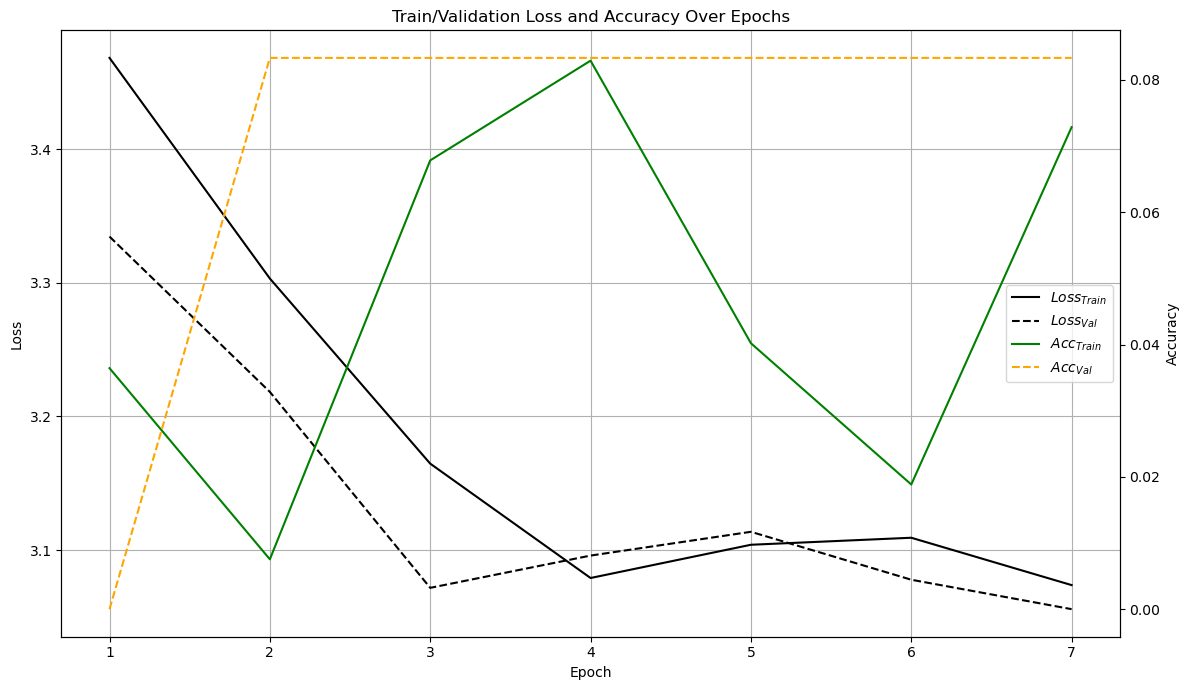

📉 Loss plot saved as:
  - training_output/ViT_bs512_ep10_lr1e-04_ds1000_g1/train_loss_and_accuracy_per_epoch_plot.png
  - training_output/ViT_bs512_ep10_lr1e-04_ds1000_g1/train_loss_and_accuracy_per_epoch_plot.pdf


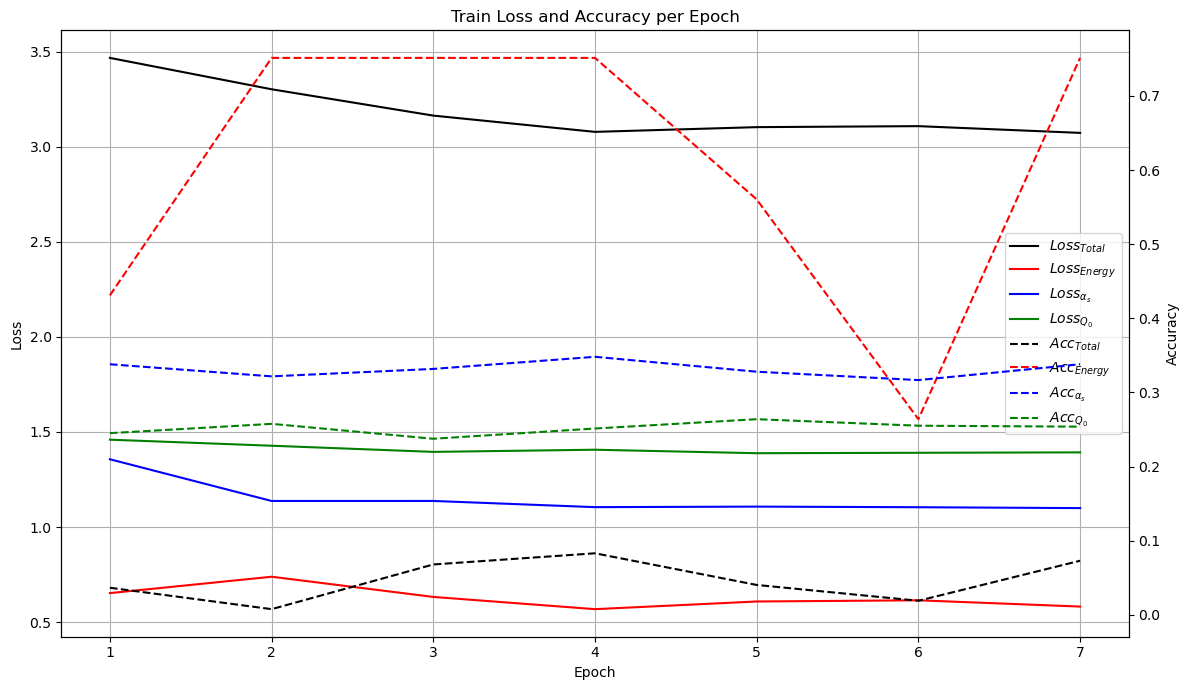

📉 Loss plot saved as:
  - training_output/ViT_bs512_ep10_lr1e-04_ds1000_g1/validation_loss_and_accuracy_per_epoch_plot.png
  - training_output/ViT_bs512_ep10_lr1e-04_ds1000_g1/validation_loss_and_accuracy_per_epoch_plot.pdf


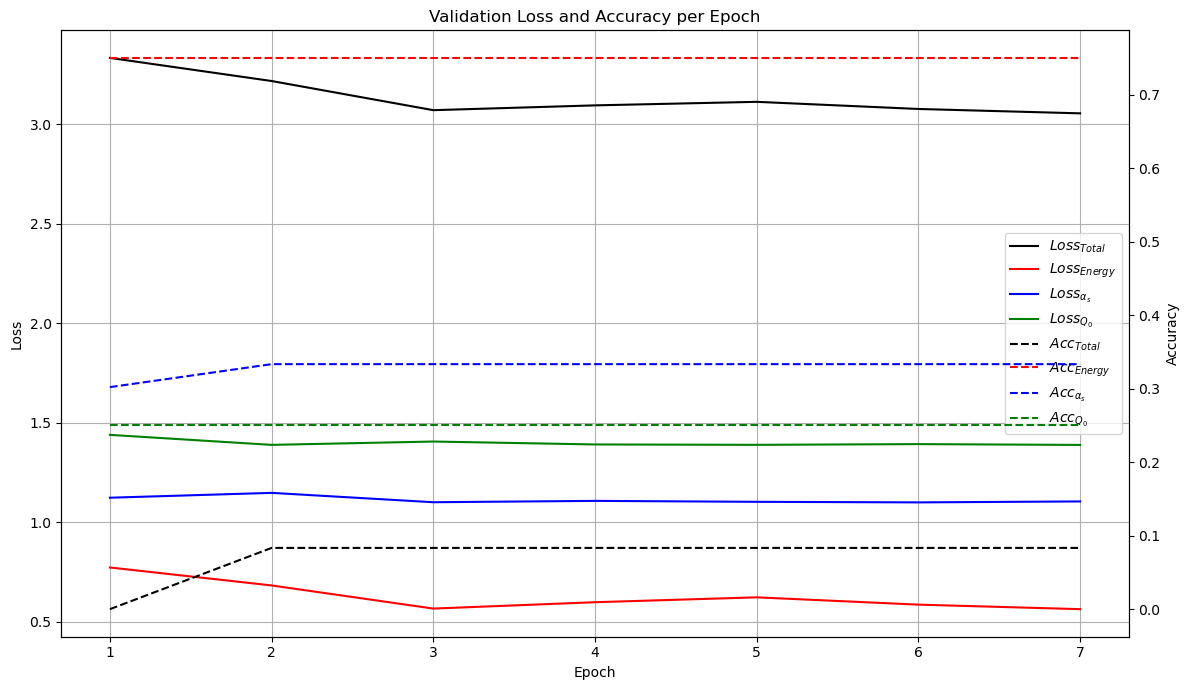

In [14]:
plot_train_val_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list, cfg.output_dir)
plot_loss_accuracy(train_loss_list,
                    train_loss_energy_list,
                    train_loss_alpha_list,
                    train_loss_q0_list,
                    train_acc_list,
                    train_acc_energy_list,
                    train_acc_alpha_list,
                    train_acc_q0_list,
                    cfg.output_dir,
                    title="Train Loss and Accuracy per Epoch")
plot_loss_accuracy(val_loss_list,
                    val_loss_energy_list,
                    val_loss_alpha_list,
                    val_loss_q0_list,
                    val_acc_list,
                    val_acc_energy_list,
                    val_acc_alpha_list,
                    val_acc_q0_list,
                    cfg.output_dir,
                    title="Validation Loss and Accuracy per Epoch")